## Lab 2: Supervised Learning

In this lab, we will investigate the determining factors of a loan size, how much of a loan gets funded, and how long it takes a loan to get funded

### Import Packages

In [2]:
from ggplot import *
import pandas as pd
import numpy as np
import re
%matplotlib inline

/Users/erourke/anaconda/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/erourke/anaconda/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/erourke/anaconda/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Load the Data

In [3]:
data_path = '/Users/erourke/Desktop'
loans_full = pd.read_csv(data_path+'/loans_full.csv', low_memory=False)
loans_details = pd.read_csv(data_path+'/loans_details.csv', low_memory=False)

In [4]:
additional_columns =  loans_full.columns.difference(loans_details.columns).tolist() + ['id']
df = loans_details.merge(loans_full[['id', 'borrower_count']], left_on='id', right_on='id')
df.head(3)

,Unnamed: 0,activity,basket_amount,bonus_credit_eligibility,borrowers,currency_exchange_loss_amount,description.languages,description.texts.en,description.texts.es,description.texts.fr,...,terms.scheduled_payments,themes,translator.byline,translator.image,use,video.id,video.thumbnailImageId,video.title,video.youtubeId,borrower_count
0,0,Farming,0.0,False,"[{'first_name': 'Evaline', 'last_name': '', 'g...",NaN,['en'],Evaline is a married lady aged 44 years old an...,NaN,NaN,...,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Julie Keaton,892591.0,to purchase more tea leaves to sell to the tea...,NaN,NaN,NaN,NaN,1
1,1,Furniture Making,0.0,False,"[{'first_name': 'Julias', 'last_name': '', 'ge...",NaN,['en'],Aged 42 years is a man by the name of Julias. ...,NaN,NaN,...,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...",NaN,Morena Calvo,1832928.0,to buy timber to make more furniture for his e...,NaN,NaN,NaN,NaN,1
2,2,Home Energy,0.0,False,"[{'first_name': 'Rose', 'last_name': '', 'gend...",NaN,['en'],"Hello Kiva Community! <br /><br />Meet Rose, w...",NaN,NaN,...,"[{'due_date': '2017-07-01T07:00:00Z', 'amount'...","['Green', 'Earth Day Campaign']",Julie Keaton,892591.0,to buy a solar lantern.,NaN,NaN,NaN,NaN,1


In [105]:
list(df)

['Unnamed: 0',
 'activity',
 'basket_amount',
 'bonus_credit_eligibility',
 'borrowers',
 'currency_exchange_loss_amount',
 'description.languages',
 'description.texts.en',
 'description.texts.es',
 'description.texts.fr',
 'description.texts.ru',
 'funded_amount',
 'funded_date',
 'id',
 'image.id',
 'image.template_id',
 'journal_totals.bulkEntries',
 'journal_totals.entries',
 'lender_count',
 'loan_amount',
 'location.country',
 'location.country_code',
 'location.geo.level',
 'location.geo.pairs',
 'location.geo.type',
 'location.town',
 'name',
 'partner_id',
 'payments',
 'planned_expiration_date',
 'posted_date',
 'sector',
 'status',
 'tags',
 'terms.disbursal_amount',
 'terms.disbursal_currency',
 'disbursal_date',
 'terms.loan_amount',
 'terms.local_payments',
 'terms.loss_liability.currency_exchange',
 'terms.loss_liability.currency_exchange_coverage_rate',
 'terms.loss_liability.nonpayment',
 'terms.repayment_interval',
 'terms.repayment_term',
 'terms.scheduled_payments'

### Creating Columns of interest

In [104]:
## Demographic variables

df['male'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]=='M')
df['widowed'] = np.where(df['description.texts.en'].str.contains("widowed|widow", na=False) ==True, True, False)
df['kids'] = np.where(df['description.texts.en'].str.contains("kids|child|children|kid|son|daughter", na=False) ==True,True,False)


## Features of the posting
df['video'] = np.where(pd.isnull(df['video.id']) ==False, True, False)
df['pictured'] = df['borrowers'].apply(lambda x: x.split("gender': '")[1][0]==True)

## Time based variables: Specifically, how long it takes a loan to get funded and dispursed

from datetime import datetime
df = df.rename(columns={'terms.disbursal_date': 'disbursal_date'})

## convert columns to datetime format
df['funded_date_cln'] = pd.to_datetime(df.funded_date.str[:10], infer_datetime_format=True)
df['post_date_cln'] = pd.to_datetime(df.posted_date.str[:10], infer_datetime_format=True)
df['disb_date_cln'] = pd.to_datetime(df.disbursal_date.str[:10], infer_datetime_format=True)
df['exp_date_cln'] = pd.to_datetime(df.planned_expiration_date.str[:10], infer_datetime_format=True)

## Time to fund is the funded date minues the posted date
df['time_to_fund'] =df['funded_date_cln'] - df['post_date_cln']
df['days_to_fund'] = df.time_to_fund.dt.days

## Time to dispursement is the Disbursed date minus the Posted Date
df['time_to_disb'] =df['disb_date_cln'] - df['post_date_cln']
df['days_to_disb'] = df.time_to_disb.dt.days

## Time to expiration is the expiration date minus the Posted Date
df['time_to_exp'] =df['exp_date_cln'] - df['post_date_cln']
df['days_to_exp'] = df.time_to_exp.dt.days

### Linear Relationships and Implications

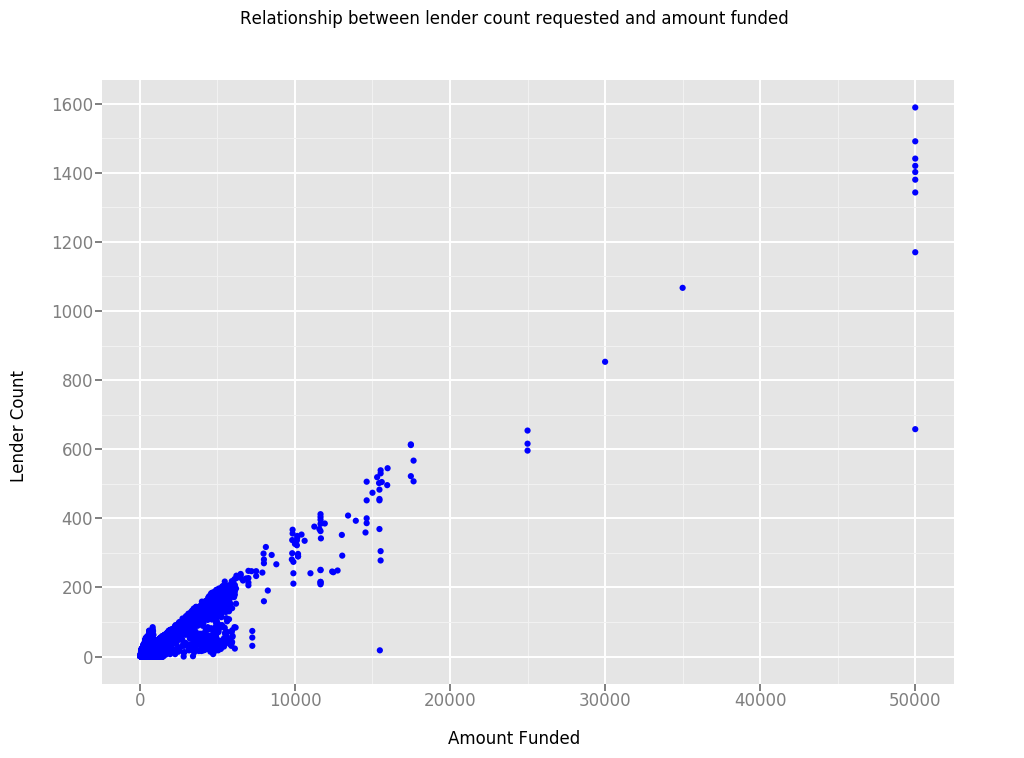

<ggplot: (-9223372036515673628)>

In [7]:
## Example of a linear relationship: What is the relationship between a loan amount and the lender count?

ggplot(loans_full, aes(x='loan_amount', y='lender_count')) + geom_point(color = "blue") + \
ggtitle("Relationship between lender count requested and amount funded") + xlab("Amount Funded") + ylab("Lender Count")

## There seem to be some really large loans skewing the view -- we can zoom in on the loans <$2000 to see 
## the relationship more clearly

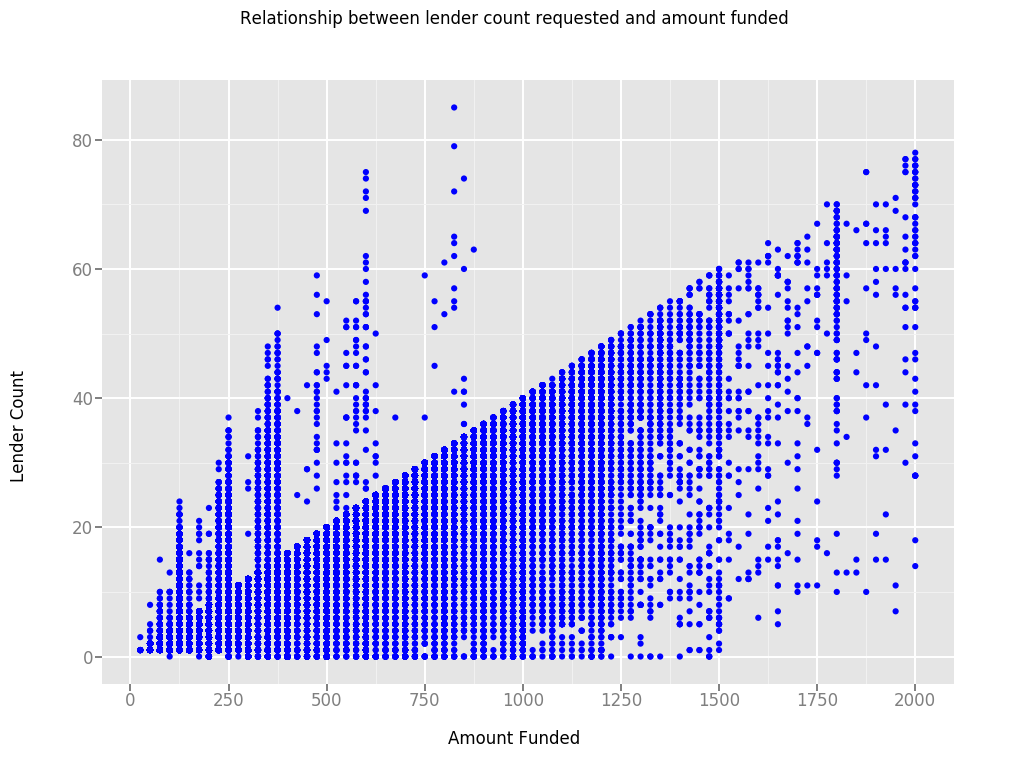

<ggplot: (344530166)>

In [19]:
ggplot(loans_full.query("loan_amount <= 2000"), aes(x='loan_amount', y='lender_count')) + geom_point(color = "blue") + \
ggtitle("Relationship between lender count requested and amount funded") + xlab("Amount Funded") + ylab("Lender Count")

## Interestingly, we see a clear linear path getting traced along a 1:25 ratio of lenders to loan amount
## What happens if we color by loan status?

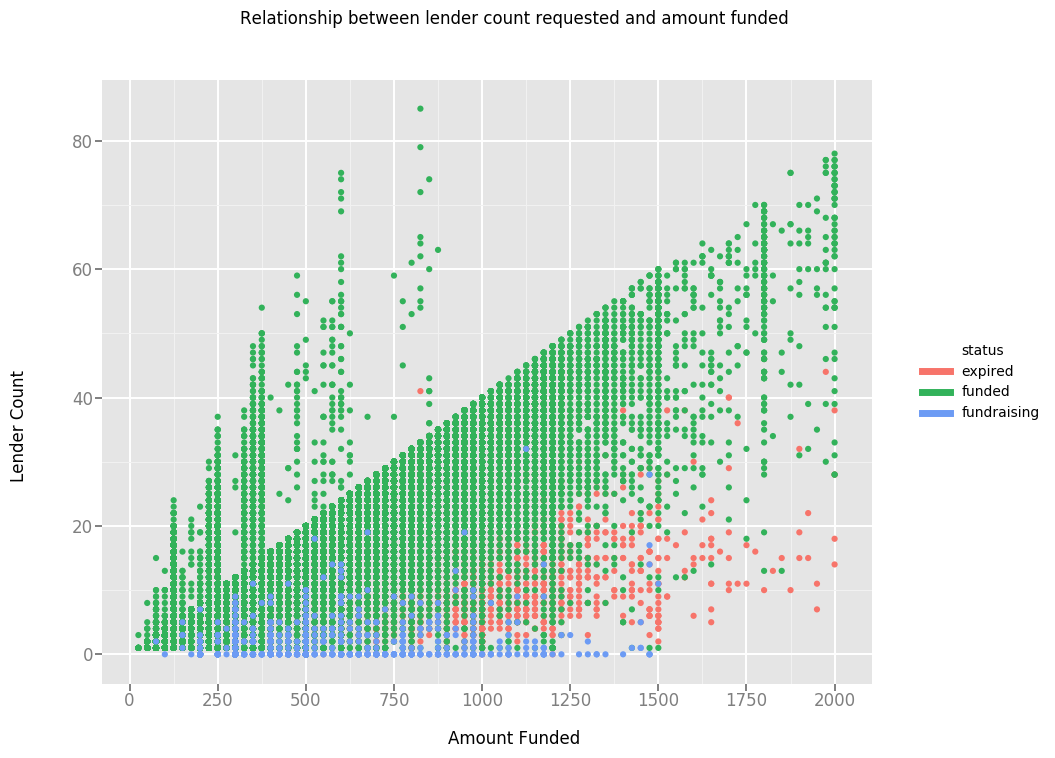

<ggplot: (344531215)>

In [20]:
ggplot(loans_full.query("loan_amount <= 2000"), aes(x='loan_amount', y='lender_count', color='status')) + geom_point() + \
ggtitle("Relationship between lender count requested and amount funded") + xlab("Amount Funded") + ylab("Lender Count")

## Given that lenders typically lend in $25 increments, we see that the expired loans are those that were 
## larger amounts, and did not obtain sufficient lenders

### Normal distribution of variables (plot histogram tables)

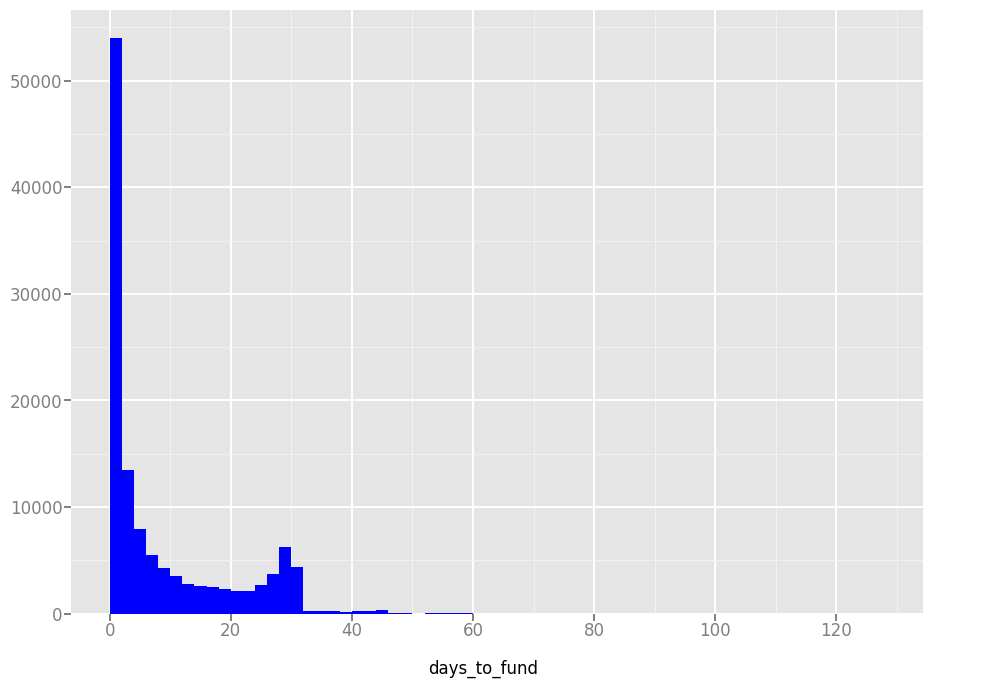

<ggplot: (305608256)>


In [40]:
h = ggplot(df.query('days_to_fund >= 0'), aes(x='days_to_fund')) + geom_histogram(binwidth=2, fill="blue")
print(h)

## Most loans are funded immediately (0 days after being posted)

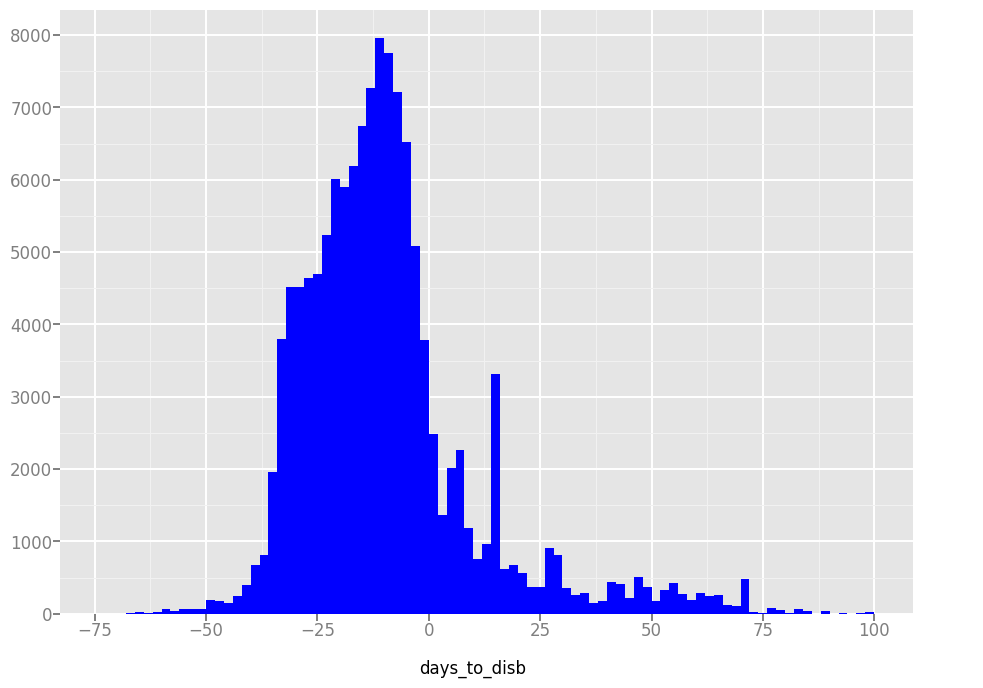

<ggplot: (305551964)>


In [46]:
h = ggplot(df.query('days_to_disb < 100 & days_to_disb > -100'), aes(x='days_to_disb')) + geom_histogram(binwidth=2, fill="blue")
print(h)

## Days to disburse a loan exhibits a normal distribution. Interestingly, it is centered around -10
## Implying that the average loan gets disbursed to the borrower prior to getting posted

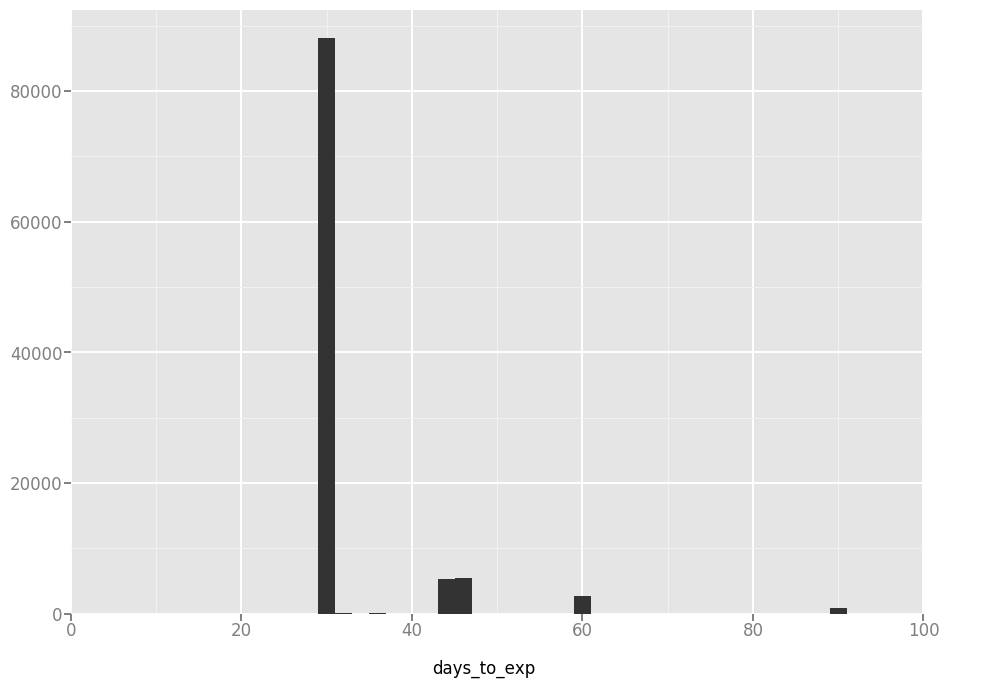

<ggplot: (-9223372036358045766)>


In [71]:
h = ggplot(df, aes(x='days_to_exp')) + geom_histogram(binwidth=2, fill="blue") + xlim(0,100)
print(h)

## most loans expire in 30 days

### Exploring Potential Relationships in the Data

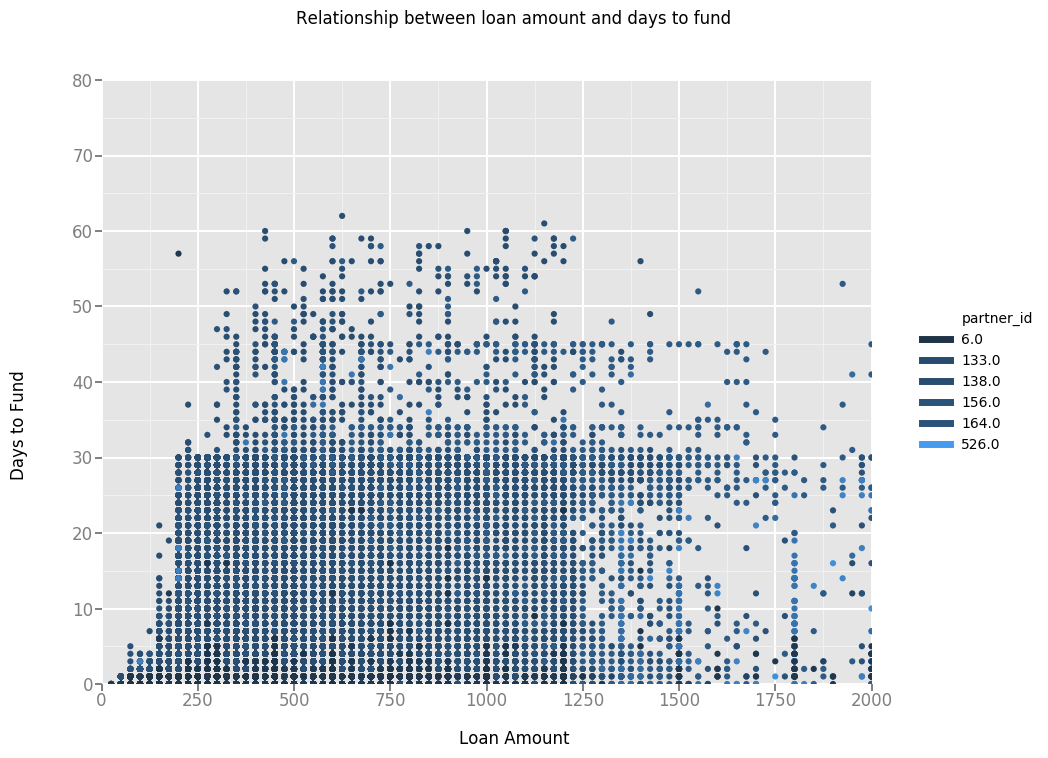

<ggplot: (-9223372036407780776)>

In [64]:
ggplot(df, aes(x='loan_amount', y='days_to_fund', color = 'partner_id')) + geom_point() + \
ggtitle("Relationship between loan amount and days to fund") + xlab("Loan Amount") + ylab("Days to Fund") + \
xlim(0,2000) + ylim(0,80)

## Clearly, the entries where funding time is negative are erroneous (set y limits accordingly)
## Here we can see the pattern where certain lenders hop in right at 30 days to fill loans that aren't yet funded

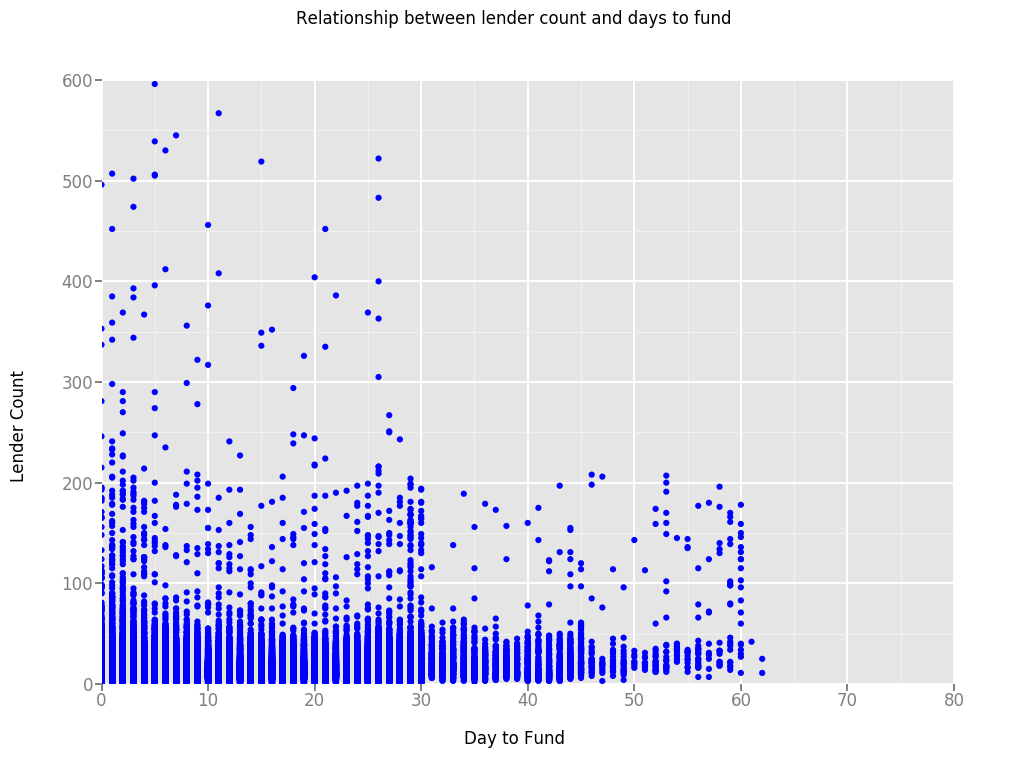

<ggplot: (478752092)>

In [70]:
ggplot(df, aes(x='days_to_fund', y='lender_count')) + geom_point(color = "blue") + \
ggtitle("Relationship between lender count and days to fund") + xlab("Day to Fund") + ylab("Lender Count") + \
xlim(0,80) + ylim(0,600)

## negative correlation between number of lenders and days to fund -- more lenders -> loan funded faster
## Clustering around 30 days ertain lenders hop in right at 30 days to fill loans that aren't yet funded

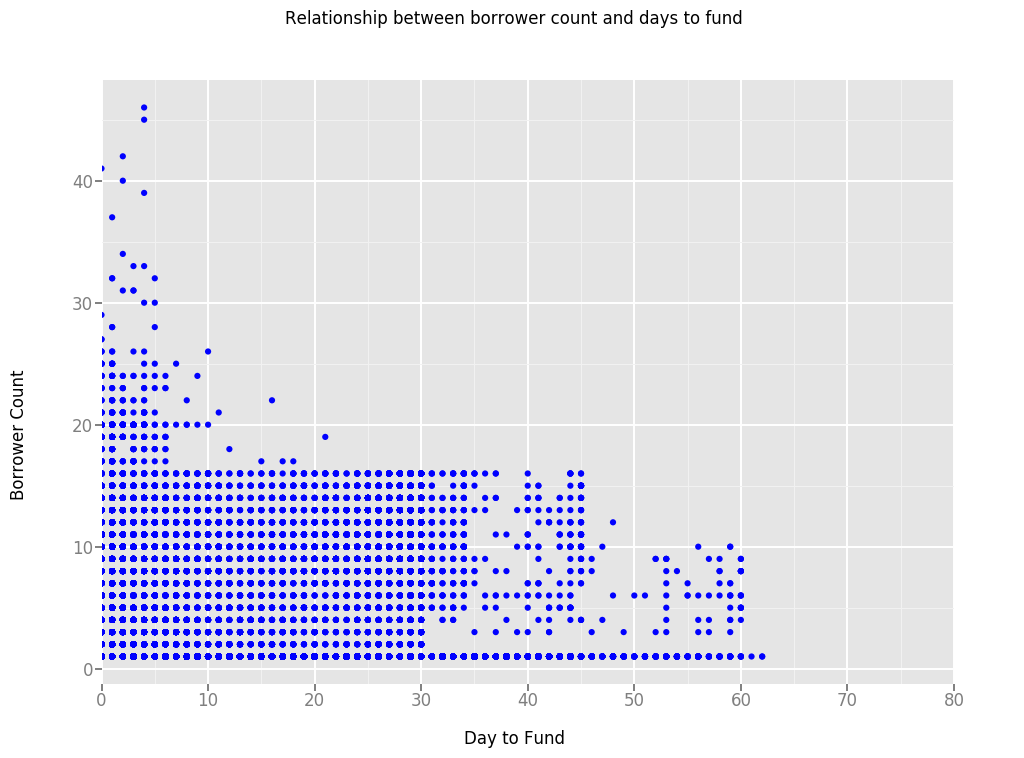

<ggplot: (-9223372036556898339)>

In [72]:
ggplot(df, aes(x='days_to_fund', y='borrower_count')) + geom_point(color = "blue") + \
ggtitle("Relationship between borrower count and days to fund") + xlab("Day to Fund") + ylab("Borrower Count") + \
xlim(0,80) 

## negative correlation between number of lenders and days to fund -- more lenders -> loan funded faster
## Clustering around 30 days ertain lenders hop in right at 30 days to fill loans that aren't yet funded

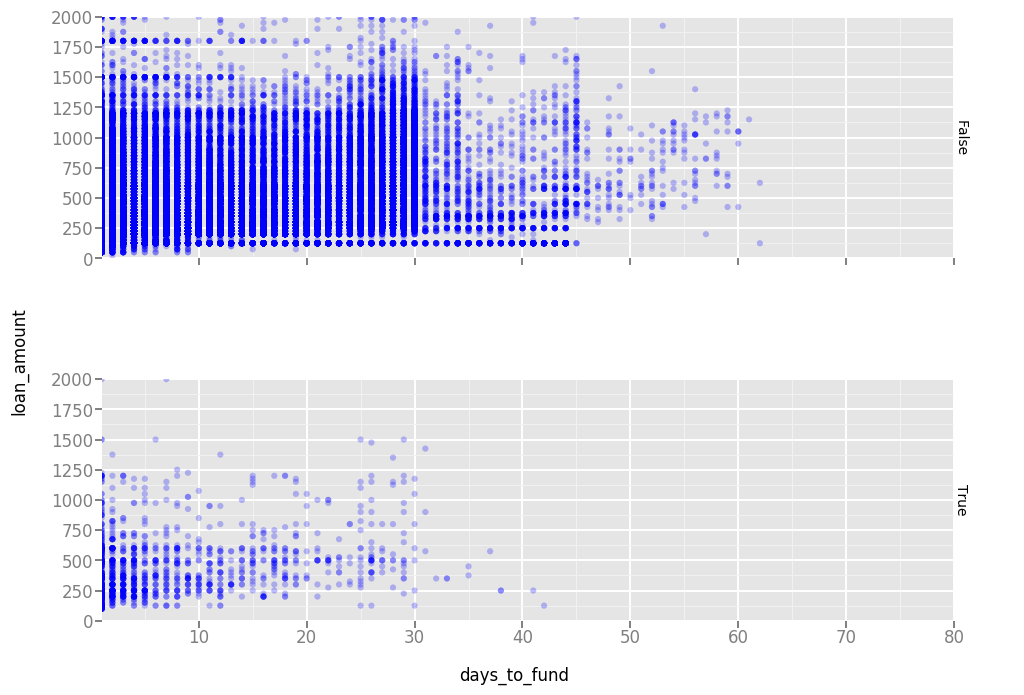

<ggplot: (-9223372036410061301)>

In [63]:
p = ggplot(df, aes(x='days_to_fund', y='loan_amount')) + xlim(1,80) + ylim(0,2000)
p + geom_point(alpha=0.25, color = 'blue') + \
    facet_grid("widowed")

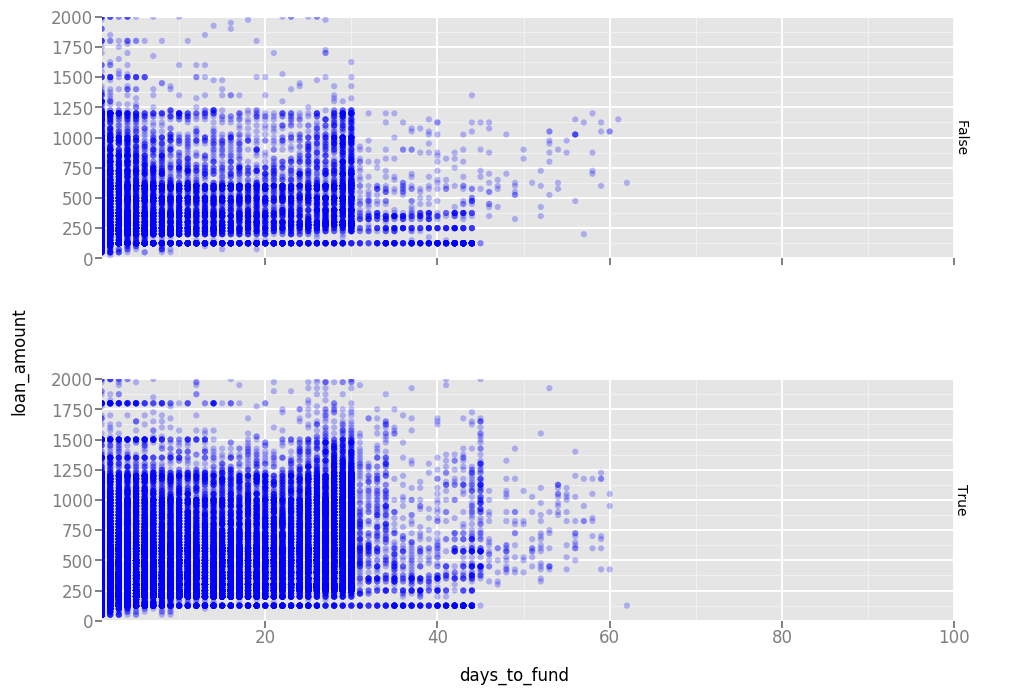

<ggplot: (309918984)>

In [61]:
p = ggplot(df, aes(x='days_to_fund', y='loan_amount')) + xlim(1,100) + ylim(0,2000)
p + geom_point(alpha=0.25, color = 'blue') + \
    facet_grid("kids")

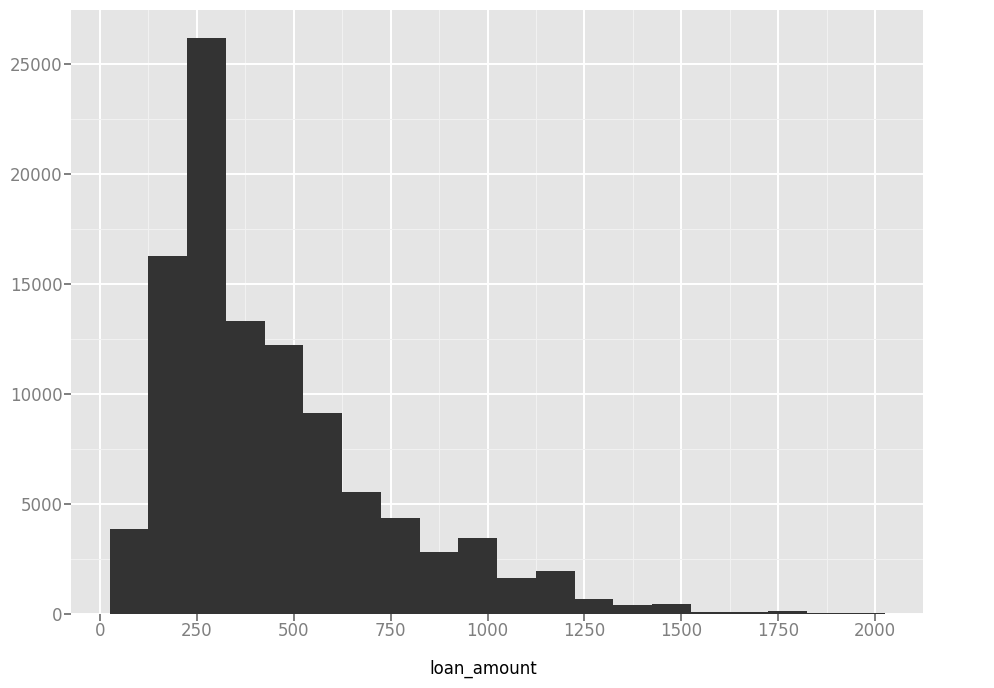

<ggplot: (-9223372036407747703)>

In [66]:
ggplot(df.query("loan_amount < 2000 & kids == 1"), aes(x='loan_amount')) + \
    geom_histogram(binwidth = 100, fill="blue")

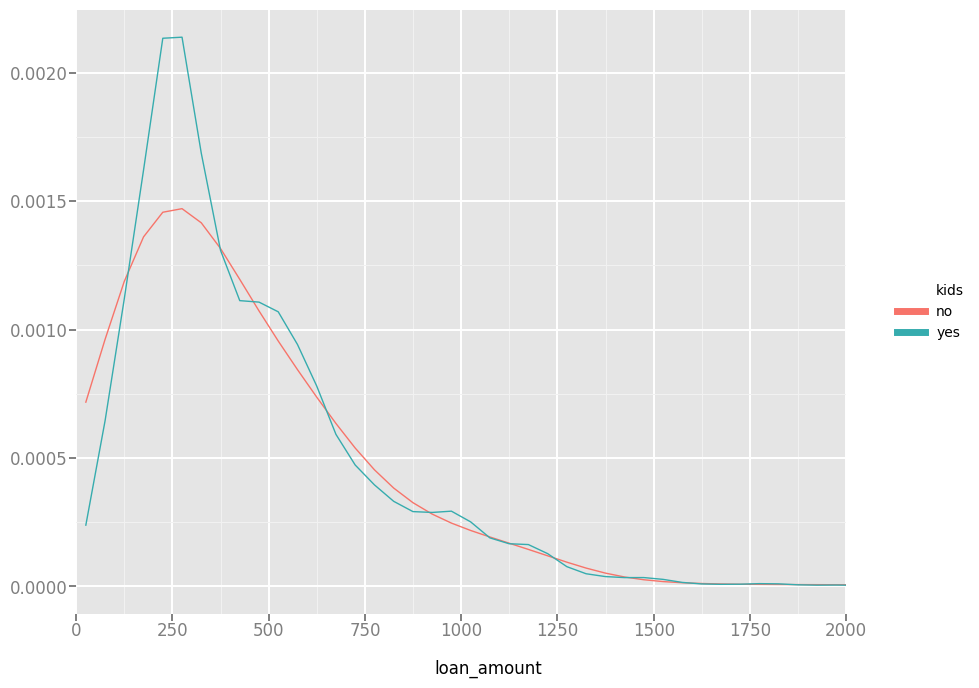

<ggplot: (362423486)>

In [128]:
ggplot(df, aes(x='loan_amount',colour=str('kids'))) + geom_density() + xlim(0,2000)

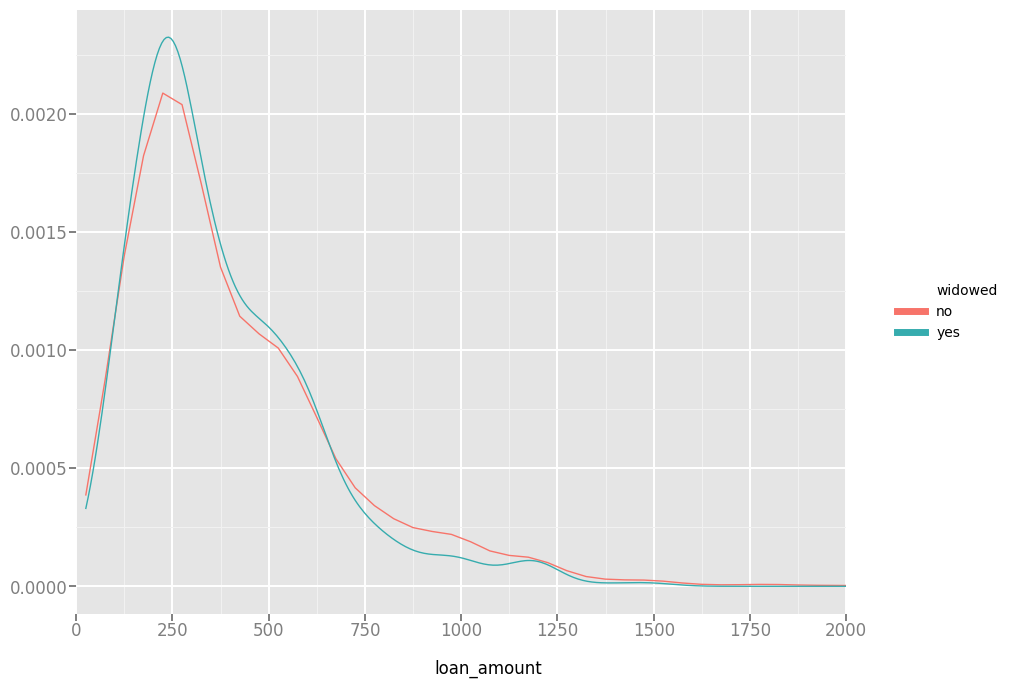

<ggplot: (416503984)>

In [131]:
## widowed women tend to receive smaller loans
ggplot(df.query('male == False'), aes(x='loan_amount',colour=str('widowed'))) + geom_density() + xlim(0,2000)

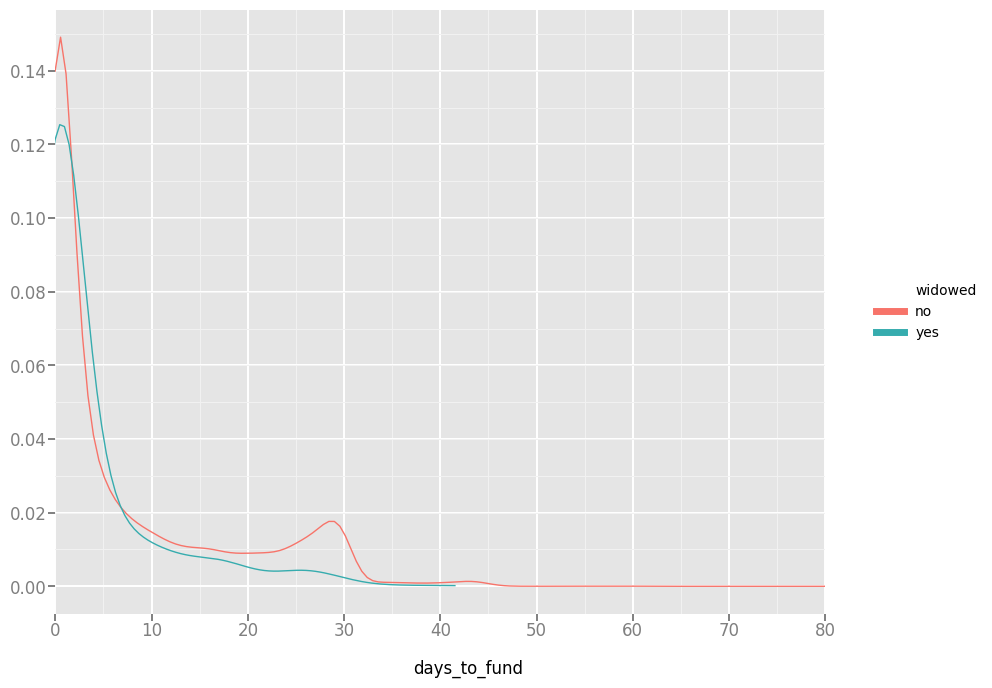

<ggplot: (-9223372036373088764)>

In [145]:
## non-widowed women take longer to fund loans
ggplot(df.query("male == False"), aes(x='days_to_fund',colour=str('widowed'))) + geom_density() + xlim(0,80)

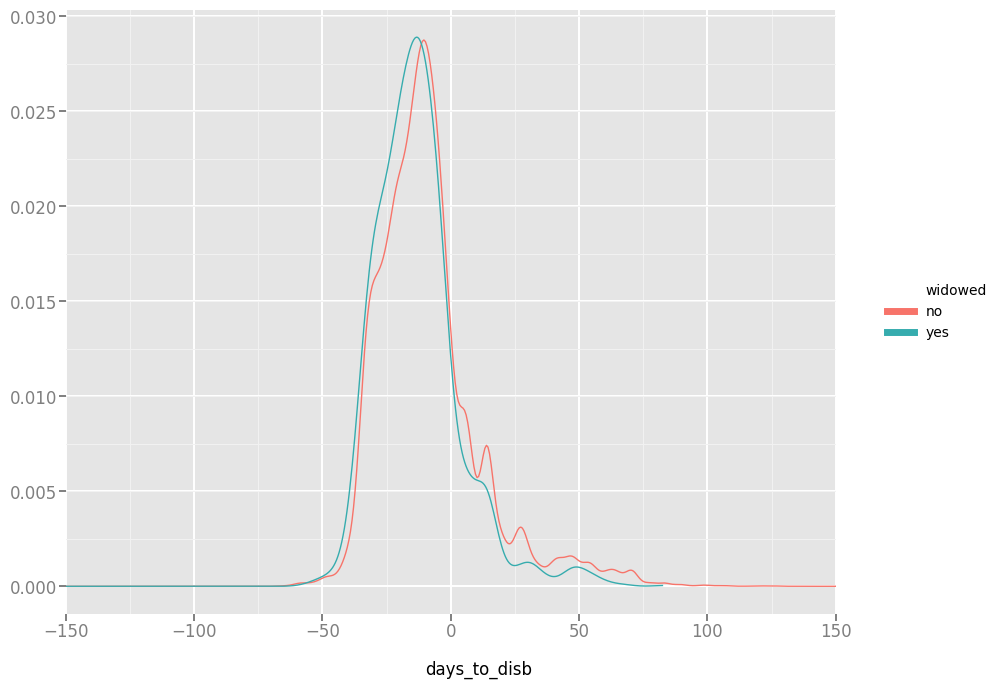

<ggplot: (-9223372036530707540)>

In [148]:
## widowed women have their loans disbursed earlier
ggplot(df.query("male == False"), aes(x='days_to_disb',colour=str('widowed'))) + geom_density() + xlim(-150,150)

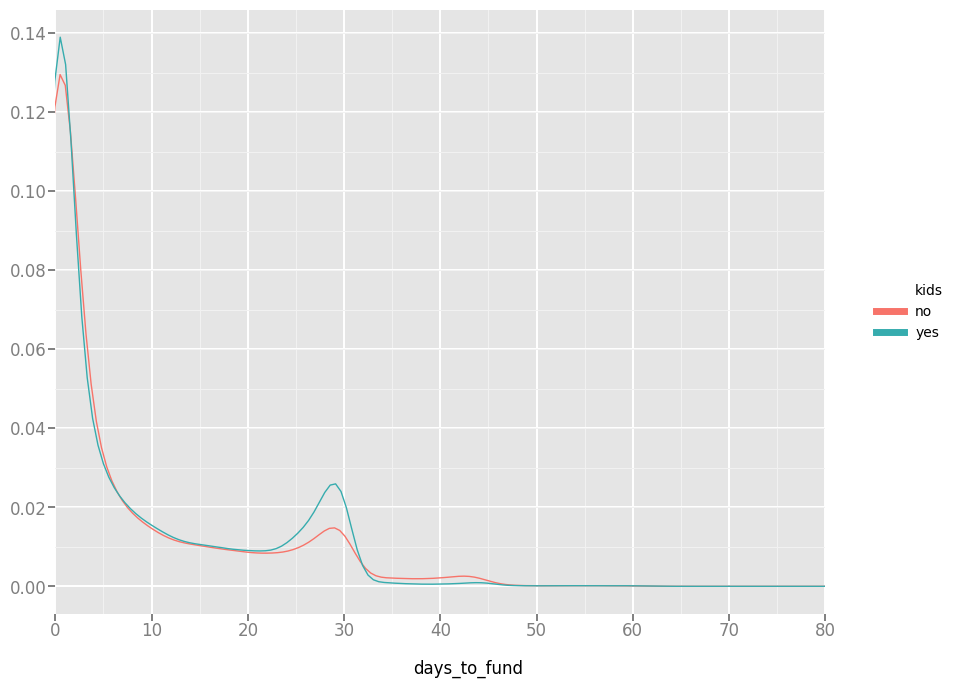

<ggplot: (491896475)>

In [143]:
ggplot(df, aes(x='days_to_fund',colour=str('kids'))) + geom_density() + xlim(0,80)

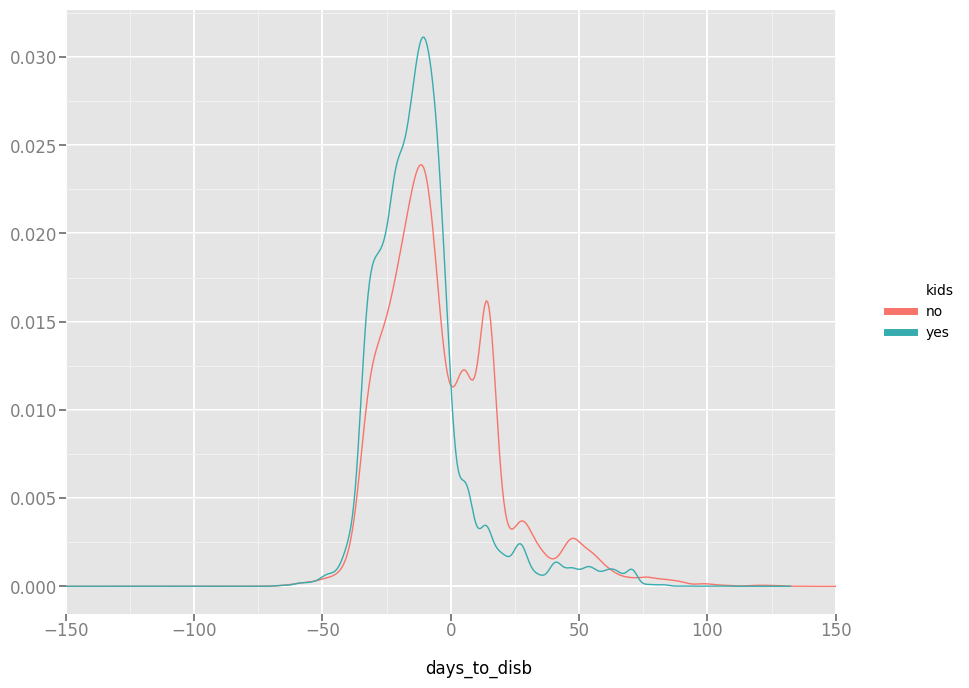

<ggplot: (-9223372036530690286)>

In [149]:
ggplot(df, aes(x='days_to_disb',colour=str('kids'))) + geom_density() + xlim(-150,150)
## loans with kids in the description get dispursed earlier

In [ ]:
ggplot(df, aes(x='days_to_fund',colour=str('kids'))) + geom_density() + xlim(-150,150)
## loans with kids in the description get dispursed earlier

## Linear Regression code ( divide into training and test, run linear regression, scatter plots of fit)

In [113]:
## LOAN AMOUNT REGRESSION

import statsmodels.formula.api as sm

# Set training-test split  
split_pct = 0.80

# the pandas command sample already randomizes. 
loans_full_shuffled = df.sample(frac=1)

train_set = loans_full_shuffled[:int((len(loans_full_shuffled)+1*split_pct))] 
test_set = loans_full_shuffled[int(len(loans_full_shuffled)*split_pct+1):]  

result = sm.ols(formula="loan_amount ~ lender_count", data=train_set).fit()

print(result.summary())


                            OLS Regression Results                            
Dep. Variable:            loan_amount   R-squared:                       0.864
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                 8.121e+05
Date:                Wed, 24 May 2017   Prob (F-statistic):               0.00
Time:                        23:18:57   Log-Likelihood:            -8.8899e+05
No. Observations:              127958   AIC:                         1.778e+06
Df Residuals:                  127956   BIC:                         1.778e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        7.8909      0.872      9.045   

In [121]:
## DAYS TO FUND REGRESSION

df = df.rename(columns={'location.geo.level': 'geo_level'})
result = sm.ols(formula="days_to_fund ~ days_to_exp + days_to_disb + borrower_count + loan_amount + sector + kids + male+ widowed + pictured + video + geo_level", data=train_set).fit()

## Interestingly widowed decreases time to fund but kids and men increases it

print(result.summary())


                            OLS Regression Results                            
Dep. Variable:           days_to_fund   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.143
Method:                 Least Squares   F-statistic:                     707.3
Date:                Wed, 24 May 2017   Prob (F-statistic):               0.00
Time:                        23:22:05   Log-Likelihood:            -3.6611e+05
No. Observations:               97418   AIC:                         7.323e+05
Df Residuals:                   97394   BIC:                         7.325e+05
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

## Validation 

In [9]:
params = result.params

params

#test_set['intercept'] = params[0]
#test_set['beta1'] = params[1]

Intercept       -8.025788
lender_count    32.026534
dtype: float64